In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
import numpy as np
import missingno

from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from category_encoders import BinaryEncoder

import tensorflow
from tensorflow.keras import optimizers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

In [2]:
df = pd.read_csv("train_data.csv")
fill_X = -0.2
threshold_train = -29
timestep_X = 10 #from 1 to 17 -> lower values give more data
timestep_y = 1 #timestep to predict
X_scaler = MinMaxScaler() #NO CAMBIAR
y_scaler = MinMaxScaler() #NO CAMBIAR

In [3]:
#Dropping first the empty column and then rows with NaNs
df = df.drop("c_rcs_estimate", axis=1)
df = df.dropna(how='any')

#Filtering events with len=1 or min_tca > 2 or max_tca < 2
def conditions(event):
    x = event["time_to_tca"].values
    return ((x.min()<2.0) & (x.max()>2.0) & (x.shape[0]>1))
df = df.groupby('event_id').filter(conditions)

#OHE for c_object_type (5 categories) -> 5 new features
#df = pd.get_dummies(df)
df = df.drop("c_object_type", axis=1)

#Binary encoder for mission_id (19 categories) -> 5 new features
#encoder = BinaryEncoder(cols=['mission_id'], drop_invariant=True)
#df = encoder.fit_transform(df)
df = df.drop("mission_id", axis=1)

#Adding feature 'event_length' for counting how many instances each event has
df["event_length"] = df.groupby('event_id')['event_id'].transform('value_counts')

#Class feature
df["class"] = df["risk"] >= threshold_train

#Fitting the scaler X
X_scaler = X_scaler.fit(df)

#Scaling the dataset
df = pd.DataFrame(X_scaler.fit_transform(df), columns=df.columns)

df = df[["event_id","risk","class"]]
def df_to_time_series(df):

    #Transforming dataframe into a 3D-array with overlapping windows
    data_train = []
    data_test = []
    timestep = timestep_X + timestep_y
    target_feture = list(df.columns).index("risk")
    def df_to_3darray(event, data_train, data_test):
        event = event.values
        if(timestep>=event.shape[0]):
            pad_shape = timestep + 1
            pad_event = np.zeros((pad_shape,event.shape[1]))
            pad_event.fill(fill_X)
            pad_event[-event.shape[0]:,:] = event
            event = pad_event
        for i in range(event.shape[0]-timestep):
            if(event[timestep,-1]==False):
                data_train.append(event[i:i+timestep_X,:])
            elif(event[timestep,-1]==True):
                data_test.append(event[i:i+timestep_X,:])
            else:
                print("Unexpected Value")        
        return event

    df.groupby("event_id").apply(df_to_3darray,
                                 data_train=data_train,
                                 data_test=data_test)
    data_train = np.array(data_train)
    data_test = np.array(data_test)

    #Dropping event_id and class to remove noise
    data_train = data_train[:,:,1:-1]
    data_test = data_test[:,:,1:-1]
    
    return data_train, data_test

X_train, X_test = df_to_time_series(df)

print(X_train.shape, X_test.shape)

(26239, 10, 1) (24920, 10, 1)


In [4]:
lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(32, activation='selu', stateful=False, input_shape=(timestep_X, X_train.shape[2]), return_sequences=True))
lstm_autoencoder.add(LSTM(16, activation='selu', stateful=False, return_sequences=False))
lstm_autoencoder.add(RepeatVector(timestep_X))
# Decoder
lstm_autoencoder.add(LSTM(16, activation='selu', stateful=False, return_sequences=True))
lstm_autoencoder.add(LSTM(32, activation='selu', stateful=False, return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(X_train.shape[2])))

lstm_autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 32)            4352      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 16)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 16)            2112      
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 32)            6272      
_________________________________________________________________
time_distributed (TimeDistri (None, 10, 1)             33        
Total params: 15,905
Trainable params: 15,905
Non-trainable params: 0
____________________________________________________

In [5]:
epochs = 30
batch = 64
lr = 0.0001

adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=1)

lstm_autoencoder_history = lstm_autoencoder.fit(X_train, X_train, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                #shuffle=True, #OJO
                                                validation_split=0.3,
                                                verbose=1).history

Train on 18367 samples, validate on 7872 samples
Epoch 1/30
18367/18367 [==============================] - 14s 755us/sample - loss: 0.0413 - val_loss: 0.0224
Epoch 2/30
18367/18367 [==============================] - 9s 505us/sample - loss: 0.0180 - val_loss: 0.0155
Epoch 3/30
18367/18367 [==============================] - 9s 503us/sample - loss: 0.0136 - val_loss: 0.0128
Epoch 4/30
18367/18367 [==============================] - 9s 499us/sample - loss: 0.0118 - val_loss: 0.0115
Epoch 5/30
18367/18367 [==============================] - 9s 499us/sample - loss: 0.0108 - val_loss: 0.0108
Epoch 6/30
18367/18367 [==============================] - 9s 510us/sample - loss: 0.0103 - val_loss: 0.0106
Epoch 7/30
18367/18367 [==============================] - 10s 523us/sample - loss: 0.0099 - val_loss: 0.0102
Epoch 8/30
18367/18367 [==============================] - 10s 520us/sample - loss: 0.0096 - val_loss: 0.0098
Epoch 9/30
18367/18367 [==============================] - 9s 510us/sample - loss: 0.

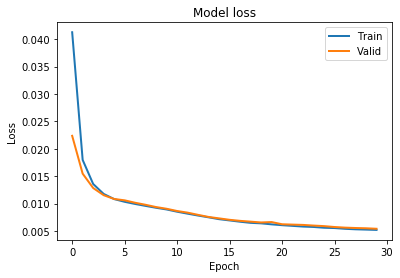

In [6]:
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [7]:
def predict_and_plot(X):
    X_pred = lstm_autoencoder.predict(X, batch_size=batch)

    X = X.reshape(X.shape[0]*X.shape[1],X.shape[2])
    X_pred = X_pred.reshape(X_pred.shape[0]*X_pred.shape[1],X_pred.shape[2])

    #X = X.astype(np.float64)
    #X_pred = X_pred.astype(np.float64)
    
    #X = X_scaler.inverse_transform(X)
    #X_pred = X_scaler.inverse_transform(X_pred)
    
    mse = np.mean(np.power(X-X_pred, 2), axis=1)
    print(mse.shape)
    df = pd.DataFrame(mse,columns=["mse"])
    fig = px.histogram(df,
                       x="mse",
                       marginal="box",
                       nbins=10)
    fig.show()
    

In [ ]:
predict_and_plot(X_train)

In [ ]:
predict_and_plot(X_test)